In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.axis import Axis
import datetime as dt

import time
start = time.time()

In [2]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data

In [3]:
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)

def period(p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


### conso.csv créé par pi4 node-red onglet Linky

In [4]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1901912 entries, 0 to 1901911
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 29.0 MB


In [5]:
conso_data['kWh']

0          0.16
1          0.16
2          0.16
3          0.16
4          0.16
           ... 
1901907    0.14
1901908    0.14
1901909    0.15
1901910    0.15
1901911    0.15
Name: kWh, Length: 1901912, dtype: float64

In [6]:
conso_data['kWh']

0          0.16
1          0.16
2          0.16
3          0.16
4          0.16
           ... 
1901907    0.14
1901908    0.14
1901909    0.15
1901910    0.15
1901911    0.15
Name: kWh, Length: 1901912, dtype: float64

In [7]:
l=len(conso_data)-1
l

1901911

In [8]:
conso_data['sec']=conso_data['Interval']/1000


In [9]:
conso_data['Wh']=3600000/conso_data['Interval']


In [10]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [11]:
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1901912 entries, 0 to 1901911
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Interval   int64  
 1   kWh        float64
 2   sec        float64
 3   Wh         float64
 4   cumul(ms)  int64  
dtypes: float64(3), int64(2)
memory usage: 72.6 MB


In [12]:
conso_data.tail()

,Interval,kWh,sec,Wh,cumul(ms)
1901907,25382,0.14,25.382,141.832795,46662260795
1901908,25074,0.14,25.074,143.575018,46662285869
1901909,24619,0.15,24.619,146.228523,46662310488
1901910,24392,0.15,24.392,147.589374,46662334880
1901911,24293,0.15,24.293,148.190837,46662359173


In [13]:
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

46662359173000

In [14]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2023, 8, 21, 21, 9, 24, 365422)

In [15]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [16]:
conso_data.iloc[0]


Interval     21934.00000
kWh              0.16000
sec             21.93400
Wh             164.12875
cumul(ms)    21934.00000
Name: 0, dtype: float64

# Recréer les dates à partir des cumuls par impulsion


In [17]:
base

datetime.datetime(2023, 8, 21, 21, 9, 24, 365422)

In [18]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0         2023-08-21 21:09:46.299422
1         2023-08-21 21:10:08.157422
2         2023-08-21 21:10:30.158422
3         2023-08-21 21:10:52.086422
4         2023-08-21 21:11:13.977422
                     ...            
1901907   2025-02-11 22:53:45.160422
1901908   2025-02-11 22:54:10.234422
1901909   2025-02-11 22:54:34.853422
1901910   2025-02-11 22:54:59.245422
1901911   2025-02-11 22:55:23.538422
Name: dates, Length: 1901912, dtype: datetime64[ns]

## créer les dates

In [19]:
# create column 'days' avec format 'dd/mm/yy'
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:09:46.299422,21/08/23
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:10:08.157422,21/08/23
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:10:30.158422,21/08/23
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:10:52.086422,21/08/23
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:11:13.977422,21/08/23
...,...,...,...,...,...,...,...
1901907,25382,0.14,25.382,141.832795,46662260795,2025-02-11 22:53:45.160422,11/02/25
1901908,25074,0.14,25.074,143.575018,46662285869,2025-02-11 22:54:10.234422,11/02/25
1901909,24619,0.15,24.619,146.228523,46662310488,2025-02-11 22:54:34.853422,11/02/25
1901910,24392,0.15,24.392,147.589374,46662334880,2025-02-11 22:54:59.245422,11/02/25


### save conso_data with dates

In [20]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [21]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
today, date, month, year


('11/02/25', 11, 2, 2025)

In [22]:
here = now.strftime('%H:%M:%S')
here

'22:55:58'

In [23]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [24]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3914 entries, 1897998 to 1901911
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   3914 non-null   int64         
 1   kWh        3914 non-null   float64       
 2   sec        3914 non-null   float64       
 3   Wh         3914 non-null   float64       
 4   cumul(ms)  3914 non-null   int64         
 5   dates      3914 non-null   datetime64[ns]
 6   days       3914 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 244.6+ KB


In [25]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [26]:
data = list(df_grp['kWh'])
print(data)

[0.567, 3.701, 4.23, 3.683, 3.961, 4.592, 3.722, 3.464, 3.5, 3.706, 3.434, 4.128, 4.231, 3.662, 3.631, 3.639, 3.318, 3.374, 4.059, 4.046, 4.011, 4.096, 3.505, 4.253, 3.955, 3.748, 4.111, 4.624, 4.125, 3.219, 3.172, 3.872, 3.803, 3.081, 3.788, 4.161, 3.618, 3.725, 4.577, 4.301, 4.429, 3.899, 3.445, 4.265, 3.915, 3.784, 3.532, 3.947, 3.771, 3.452, 4.126, 3.386, 3.829, 3.887, 3.603, 3.742, 4.313, 3.255, 3.87, 3.162, 2.055, 2.042, 2.297, 4.084, 3.643, 4.308, 3.63, 3.987, 3.774, 3.693, 4.214, 3.967, 3.796, 3.124, 3.768, 3.584, 3.549, 3.714, 3.674, 3.339, 3.811, 3.254, 3.752, 3.605, 4.063, 3.564, 3.532, 3.676, 4.072, 4.375, 3.928, 4.131, 4.282, 3.821, 3.868, 3.836, 3.792, 3.815, 4.079, 4.406, 3.876, 3.506, 3.675, 3.677, 3.348, 3.832, 3.799, 4.309, 3.527, 4.161, 3.592, 3.903, 4.678, 3.596, 3.578, 3.523, 3.972, 3.852, 4.157, 3.847, 3.839, 3.625, 5.052, 3.772, 3.675, 4.267, 4.218, 4.359, 4.506, 4.145, 3.656, 4.462, 4.706, 4.106, 4.756, 4.486, 3.66, 4.047, 3.903, 3.616, 3.567, 3.955, 3.662, 3.72

In [27]:
# save to file
import pickle
path = r'kwh_mean.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

In [28]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


In [29]:
df = conso_data
len(df)

1901912

In [30]:
period(p=2)

2023-08-22 03:16:00.102422	2023-08-22 10:20:15.722422	7h 4m 15s 	2000


In [31]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.300097
dtype: float64

In [32]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.515549
dtype: float64

In [33]:
last=df_grp.iloc[-1]['kWh']
last

3.914

In [34]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3914 entries, 1897998 to 1901911
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   3914 non-null   int64         
 1   kWh        3914 non-null   float64       
 2   sec        3914 non-null   float64       
 3   Wh         3914 non-null   float64       
 4   cumul(ms)  3914 non-null   int64         
 5   dates      3914 non-null   datetime64[ns]
 6   days       3914 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 244.6+ KB


In [35]:
# select day
day = today
#day = '16/08/24'


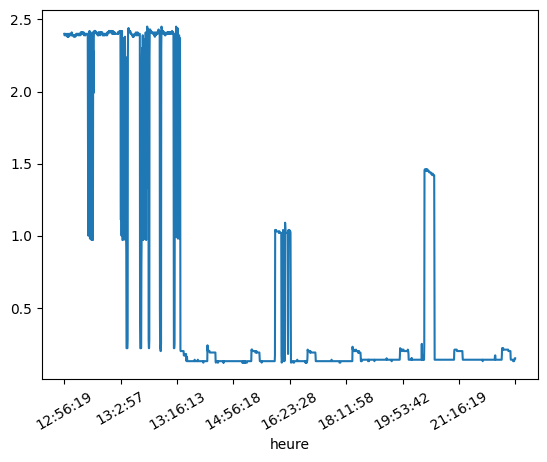

In [36]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df= conso_day.set_index('heure')
df.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [37]:
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:09:46.299422,21/08/23
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:10:08.157422,21/08/23
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:10:30.158422,21/08/23
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:10:52.086422,21/08/23
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:11:13.977422,21/08/23
...,...,...,...,...,...,...,...
1901907,25382,0.14,25.382,141.832795,46662260795,2025-02-11 22:53:45.160422,11/02/25
1901908,25074,0.14,25.074,143.575018,46662285869,2025-02-11 22:54:10.234422,11/02/25
1901909,24619,0.15,24.619,146.228523,46662310488,2025-02-11 22:54:34.853422,11/02/25
1901910,24392,0.15,24.392,147.589374,46662334880,2025-02-11 22:54:59.245422,11/02/25


In [38]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
heure,,,,,,,
0:0:3,26488,0.14,26.488,135.910601,46579839418,2025-02-11 00:00:03.783422,11/02/25
0:0:28,24903,0.14,24.903,144.560896,46579864321,2025-02-11 00:00:28.686422,11/02/25
0:0:53,24399,0.15,24.399,147.547031,46579888720,2025-02-11 00:00:53.085422,11/02/25
0:1:17,24755,0.14,24.755,145.425167,46579913475,2025-02-11 00:01:17.840422,11/02/25
0:1:43,25419,0.14,25.419,141.626342,46579938894,2025-02-11 00:01:43.259422,11/02/25
...,...,...,...,...,...,...,...
22:53:45,25382,0.14,25.382,141.832795,46662260795,2025-02-11 22:53:45.160422,11/02/25
22:54:10,25074,0.14,25.074,143.575018,46662285869,2025-02-11 22:54:10.234422,11/02/25
22:54:34,24619,0.15,24.619,146.228523,46662310488,2025-02-11 22:54:34.853422,11/02/25


In [39]:
# group by hour, df  = data of a chosen day
df_byhour = df[['days','kWh']].groupby('heure', sort=False)
kwh_byhour = df_byhour['kWh']



Max : 22/01/25 4.786
Min : 31/01/25 2.818


,Interval,kWh,sec,Wh,cumul(ms),dates,days,heure
1897998,26488,0.14,26.488,135.910601,46579839418,2025-02-11 00:00:03.783422,11/02/25,0:0:3
1897999,24903,0.14,24.903,144.560896,46579864321,2025-02-11 00:00:28.686422,11/02/25,0:0:28
1898000,24399,0.15,24.399,147.547031,46579888720,2025-02-11 00:00:53.085422,11/02/25,0:0:53
1898001,24755,0.14,24.755,145.425167,46579913475,2025-02-11 00:01:17.840422,11/02/25,0:1:17
1898002,25419,0.14,25.419,141.626342,46579938894,2025-02-11 00:01:43.259422,11/02/25,0:1:43
...,...,...,...,...,...,...,...,...
1901907,25382,0.14,25.382,141.832795,46662260795,2025-02-11 22:53:45.160422,11/02/25,22:53:45
1901908,25074,0.14,25.074,143.575018,46662285869,2025-02-11 22:54:10.234422,11/02/25,22:54:10
1901909,24619,0.15,24.619,146.228523,46662310488,2025-02-11 22:54:34.853422,11/02/25,22:54:34
1901910,24392,0.15,24.392,147.589374,46662334880,2025-02-11 22:54:59.245422,11/02/25,22:54:59


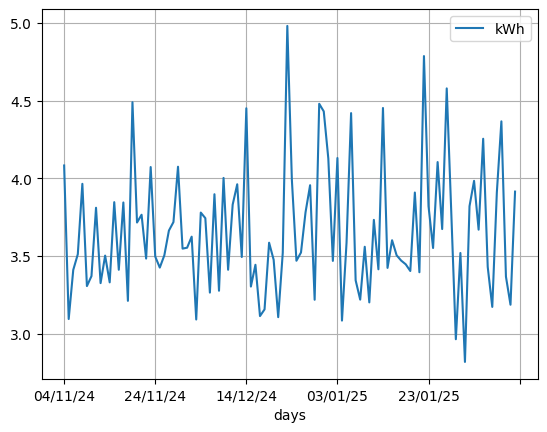

In [40]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
df.iloc[0].dates
df.dates.dt.time

# save data
df_grp.to_csv('df_grp.csv')
df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp.info()
df_grp.mean()
#df_grp.head()
df_grp.tail(14)
df_grp.tail(100).mean()
df_grp.tail(100).plot()
plt.grid()
# max min during last month
#print(df_grp.iloc[-31:-1])
df_grp.iloc[-31:-1].describe()

month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))
conso_day


2025-02-11 00:00:03.783422	2025-02-11 08:12:00.801422	8h 11m 57s 	1000
2025-02-11 08:12:00.801422	2025-02-11 12:58:27.187422	4h 46m 26s 	2000
2025-02-11 12:58:27.187422	2025-02-11 17:00:14.529422	4h 1m 47s 	3000
2025-02-11 17:00:14.529422	2025-02-11 22:55:23.538422	5h 55m 9s 	914
<class 'pandas.core.frame.DataFrame'>
Index: 3914 entries, 1897998 to 1901911
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   3914 non-null   int64         
 1   kWh        3914 non-null   float64       
 2   sec        3914 non-null   float64       
 3   Wh         3914 non-null   float64       
 4   cumul(ms)  3914 non-null   int64         
 5   dates      3914 non-null   datetime64[ns]
 6   days       3914 non-null   object        
 7   heure      3914 non-null   object        
 8   hours      3914 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 305.8+ KB


('11/02/25', <Axes: xlabel='hours'>)

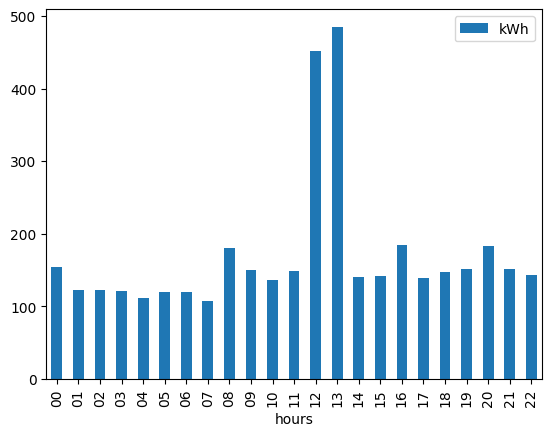

In [41]:

tranches = len(df)//1000
tranches+1
# temps de conso par tranches de 1kwh
for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
    if len(df)>(p-1)*1000:
        period(p)
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()

conso_hours
# group conso of the day by hour
groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
list(groupedbyhour)
day, groupedbyhour.count().plot.bar()

In [42]:
df_grp

,kWh
days,
21/08/23,0.567
22/08/23,3.701
23/08/23,4.230
24/08/23,3.683
25/08/23,3.961
...,...
07/02/25,3.908
08/02/25,4.366
09/02/25,3.367


In [43]:
# select number of days to display
span = 30
#df_grp.tail(span)


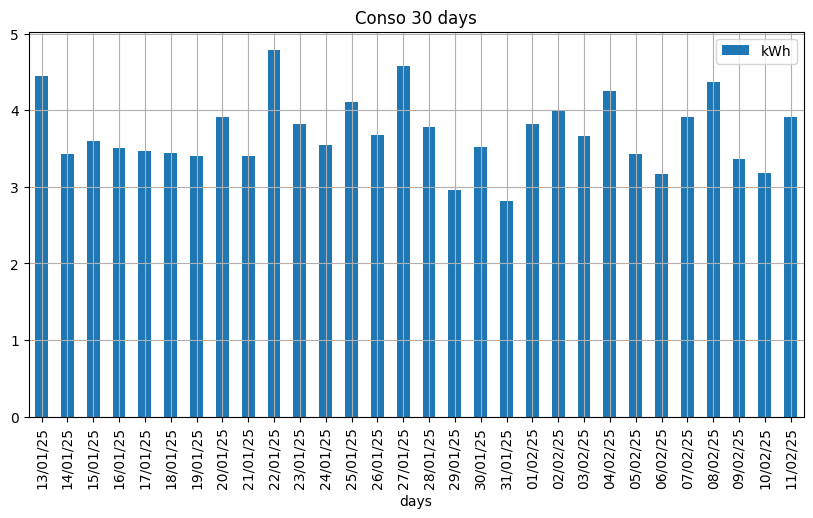

In [44]:

# Plot the figure without labels
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight') 
plt.title(f'Conso {span} days')
plt.xticks(rotation=90);


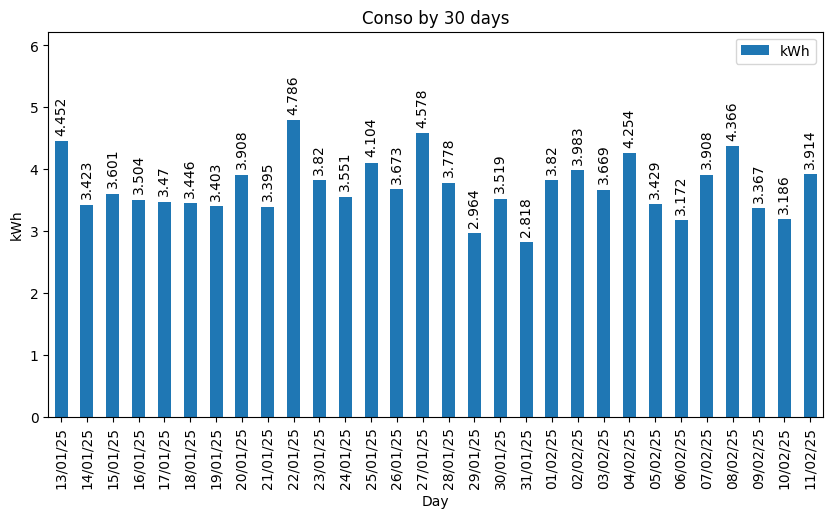

In [45]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
ax.set_title(f"Conso by {span} days")
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [46]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
13/01/25    4.452
14/01/25    3.423
15/01/25    3.601
16/01/25    3.504
17/01/25    3.470
18/01/25    3.446
19/01/25    3.403
20/01/25    3.908
21/01/25    3.395
22/01/25    4.786
23/01/25    3.820
24/01/25    3.551
25/01/25    4.104
26/01/25    3.673
27/01/25    4.578
28/01/25    3.778
29/01/25    2.964
30/01/25    3.519
31/01/25    2.818
01/02/25    3.820
02/02/25    3.983
03/02/25    3.669
04/02/25    4.254
05/02/25    3.429
06/02/25    3.172
07/02/25    3.908
08/02/25    4.366
09/02/25    3.367
10/02/25    3.186
11/02/25    3.914
Name: kWh, dtype: float64

In [47]:
x_labels=df_grp.tail(span).index
x_labels

Index(['13/01/25', '14/01/25', '15/01/25', '16/01/25', '17/01/25', '18/01/25',
       '19/01/25', '20/01/25', '21/01/25', '22/01/25', '23/01/25', '24/01/25',
       '25/01/25', '26/01/25', '27/01/25', '28/01/25', '29/01/25', '30/01/25',
       '31/01/25', '01/02/25', '02/02/25', '03/02/25', '04/02/25', '05/02/25',
       '06/02/25', '07/02/25', '08/02/25', '09/02/25', '10/02/25', '11/02/25'],
      dtype='object', name='days')

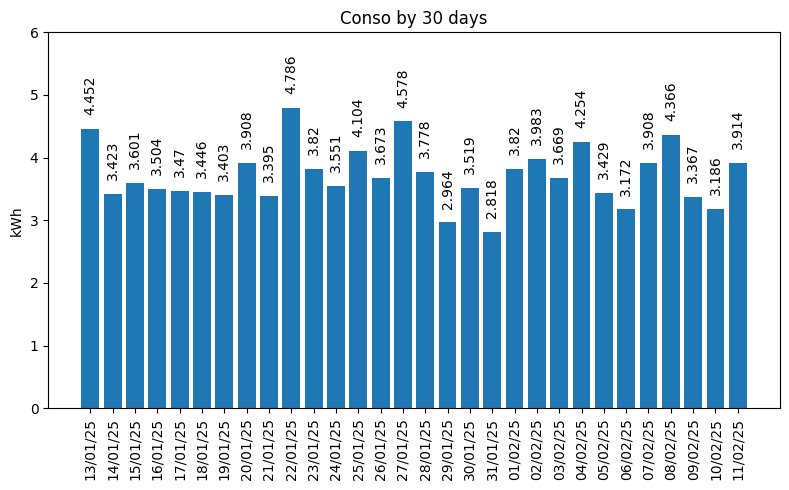

In [48]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
ax.set(ylabel='kWh', title=f'Conso by {span} days', ylim=(0, 6))
plt.xticks(rotation=90);


In [49]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

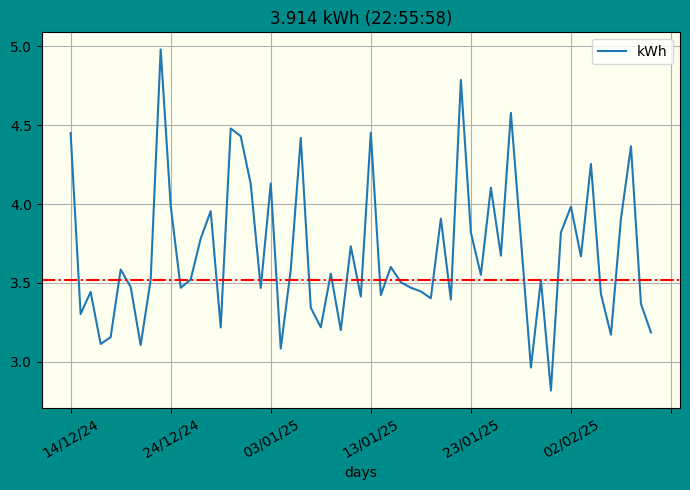

In [50]:
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

# 2 last months
df_grp.iloc[-60:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(str(last)+' kWh ('+str(here)+')')
plt.axhline(y=np.nanmean(df_grp),c='red', ls='-.')
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

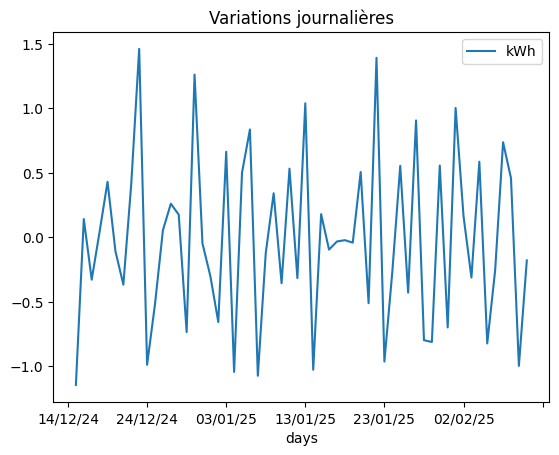

In [51]:
# variations journalières
df_grp.iloc[-60:-1].diff().plot()
plt.title('Variations journalières')

# Data from 21/08/23

In [52]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:09:46.299422,21/08/23,21
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:10:08.157422,21/08/23,21
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:10:30.158422,21/08/23,21
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:10:52.086422,21/08/23,21
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:11:13.977422,21/08/23,21
...,...,...,...,...,...,...,...,...
1901907,25382,0.14,25.382,141.832795,46662260795,2025-02-11 22:53:45.160422,11/02/25,22
1901908,25074,0.14,25.074,143.575018,46662285869,2025-02-11 22:54:10.234422,11/02/25,22
1901909,24619,0.15,24.619,146.228523,46662310488,2025-02-11 22:54:34.853422,11/02/25,22
1901910,24392,0.15,24.392,147.589374,46662334880,2025-02-11 22:54:59.245422,11/02/25,22


In [53]:
# example groupby with apply
df = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [54]:
import pandas as pd
df = pd.read_csv(r'C:\Users\jean\Downloads\only-bh-extreme-events-satellite.csv'
                  ,index_col=[0,1,2,3,4]
                  ,header=[0,1,2,3]
                  ,skipinitialspace=True
                  #,tupleize_cols=True
                ) 

df.columns = pd.MultiIndex.from_tuples(df.columns)
df.index.names

FrozenList(['wsid', 'lat', 'lon', 'start', 'prcp_24'])

In [55]:
index=df.columns.levels[0]
index

Index(['al', 'asn', 'cc', 'chnk', 'ci', 'ciwc', 'clwc', 'd', 'd2m', 'hcc',
       'istl1', 'istl2', 'istl3', 'istl4', 'lcc', 'lsrh', 'mcc', 'msl', 'o3',
       'p53.162', 'p54.162', 'p55.162', 'p56.162', 'p57.162', 'p58.162',
       'p59.162', 'p60.162', 'p61.162', 'p62.162', 'p63.162', 'p64.162',
       'p65.162', 'p66.162', 'p67.162', 'p68.162', 'p69.162', 'p70.162',
       'p71.162', 'p72.162', 'p73.162', 'p74.162', 'p75.162', 'p76.162',
       'p77.162', 'p78.162', 'p79.162', 'p80.162', 'p81.162', 'p82.162',
       'p83.162', 'p84.162', 'p85.162', 'p86.162', 'p87.162', 'p88.162',
       'p89.162', 'p90.162', 'p91.162', 'p92.162', 'pv', 'q', 'r', 'rsn', 'sd',
       'skt', 'sp', 'sr', 'src', 'sst', 'stl1', 'stl2', 'stl3', 'stl4',
       'swvl1', 'swvl2', 'swvl3', 'swvl4', 't', 't2m', 'tcc', 'tco3', 'tcw',
       'tcwv', 'tsn', 'u', 'u10', 'v', 'v10', 'vo', 'w', 'z'],
      dtype='object')

In [56]:
df_des = pd.DataFrame(
                            index=df.columns.levels[0],
                            columns=['count','mean','std','min','25','50','75','max']
                         )
df_des

,count,mean,std,min,25,50,75,max
al,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
asn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chnk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ci,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
v,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
v10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
21/08/23,567
22/08/23,3701
23/08/23,4230
24/08/23,3683
25/08/23,3961
...,...
07/02/25,3908
08/02/25,4366
09/02/25,3367


In [58]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:09:46.299422,21/08/23,21
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:10:08.157422,21/08/23,21
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:10:30.158422,21/08/23,21
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:10:52.086422,21/08/23,21
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:11:13.977422,21/08/23,21
...,...,...,...,...,...,...,...,...
1901907,25382,0.14,25.382,141.832795,46662260795,2025-02-11 22:53:45.160422,11/02/25,22
1901908,25074,0.14,25.074,143.575018,46662285869,2025-02-11 22:54:10.234422,11/02/25,22
1901909,24619,0.15,24.619,146.228523,46662310488,2025-02-11 22:54:34.853422,11/02/25,22
1901910,24392,0.15,24.392,147.589374,46662334880,2025-02-11 22:54:59.245422,11/02/25,22


In [59]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                              
21/08/23 21    0        21/08/23    21  0.16
               1        21/08/23    21  0.16
               2        21/08/23    21  0.16
               3        21/08/23    21  0.16
               4        21/08/23    21  0.16
...                          ...   ...   ...
11/02/25 22    1901907  11/02/25    22  0.14
               1901908  11/02/25    22  0.14
               1901909  11/02/25    22  0.15
               1901910  11/02/25    22  0.15
               1901911  11/02/25    22  0.15

[1901912 rows x 3 columns]

In [60]:
groupallbyday.indices.keys()

dict_keys(['21/08/23', '22/08/23', '23/08/23', '24/08/23', '25/08/23', '26/08/23', '27/08/23', '28/08/23', '29/08/23', '30/08/23', '31/08/23', '01/09/23', '02/09/23', '03/09/23', '04/09/23', '05/09/23', '06/09/23', '07/09/23', '08/09/23', '09/09/23', '10/09/23', '11/09/23', '12/09/23', '13/09/23', '14/09/23', '15/09/23', '16/09/23', '17/09/23', '18/09/23', '19/09/23', '20/09/23', '21/09/23', '22/09/23', '23/09/23', '24/09/23', '25/09/23', '26/09/23', '27/09/23', '28/09/23', '29/09/23', '30/09/23', '01/10/23', '02/10/23', '03/10/23', '04/10/23', '05/10/23', '06/10/23', '07/10/23', '08/10/23', '09/10/23', '10/10/23', '11/10/23', '12/10/23', '13/10/23', '14/10/23', '15/10/23', '16/10/23', '17/10/23', '18/10/23', '19/10/23', '20/10/23', '21/10/23', '22/10/23', '23/10/23', '24/10/23', '25/10/23', '26/10/23', '27/10/23', '28/10/23', '29/10/23', '30/10/23', '31/10/23', '01/11/23', '02/11/23', '03/11/23', '04/11/23', '05/11/23', '06/11/23', '07/11/23', '08/11/23', '09/11/23', '10/11/23', '11/1

In [61]:
groupallbydayhours.indices.keys()

dict_keys([('21/08/23', '21'), ('21/08/23', '22'), ('21/08/23', '23'), ('22/08/23', '21'), ('22/08/23', '22'), ('22/08/23', '23'), ('22/08/23', '00'), ('22/08/23', '01'), ('22/08/23', '02'), ('22/08/23', '03'), ('22/08/23', '04'), ('22/08/23', '05'), ('22/08/23', '06'), ('22/08/23', '07'), ('22/08/23', '08'), ('22/08/23', '09'), ('22/08/23', '10'), ('22/08/23', '11'), ('22/08/23', '12'), ('22/08/23', '13'), ('22/08/23', '14'), ('22/08/23', '15'), ('22/08/23', '16'), ('22/08/23', '17'), ('22/08/23', '18'), ('22/08/23', '19'), ('22/08/23', '20'), ('23/08/23', '21'), ('23/08/23', '22'), ('23/08/23', '23'), ('23/08/23', '00'), ('23/08/23', '01'), ('23/08/23', '02'), ('23/08/23', '03'), ('23/08/23', '04'), ('23/08/23', '05'), ('23/08/23', '06'), ('23/08/23', '07'), ('23/08/23', '08'), ('23/08/23', '09'), ('23/08/23', '10'), ('23/08/23', '11'), ('23/08/23', '12'), ('23/08/23', '13'), ('23/08/23', '14'), ('23/08/23', '15'), ('23/08/23', '16'), ('23/08/23', '17'), ('23/08/23', '18'), ('23/08/2

In [62]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
21/08/23,567,567
22/08/23,3701,3701
23/08/23,4230,4230
24/08/23,3683,3683
25/08/23,3961,3961
...,...,...
07/02/25,3908,3908
08/02/25,4366,4366
09/02/25,3367,3367


In [63]:
grp_by_day['kWh'].cumsum()

days
21/08/23        567
22/08/23       4268
23/08/23       8498
24/08/23      12181
25/08/23      16142
             ...   
07/02/25    1887079
08/02/25    1891445
09/02/25    1894812
10/02/25    1897998
11/02/25    1901912
Name: kWh, Length: 541, dtype: int64

In [64]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
21/08/23 21     151
         22     286
         23     130
22/08/23 00     129
         01     131
...             ...
11/02/25 18     147
         19     151
         20     183
         21     152
         22     143

[12962 rows x 1 columns]

In [65]:
grp_by_dayhours['kWh'].cumsum()

days      hours
21/08/23  21           151
          22           437
          23           567
22/08/23  00           696
          01           827
                    ...   
11/02/25  18       1901283
          19       1901434
          20       1901617
          21       1901769
          22       1901912
Name: kWh, Length: 12962, dtype: int64

In [66]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
21/08/23 21     151     151    NaN
         22     286     437  135.0
         23     130     567 -156.0
22/08/23 00     129     129    NaN
         01     131     260    2.0
...             ...     ...    ...
11/02/25 18     147    3285    8.0
         19     151    3436    4.0
         20     183    3619   32.0
         21     152    3771  -31.0
         22     143    3914   -9.0

[12962 rows x 3 columns]

In [67]:
today, grp_by_dayhours.loc[today]

('11/02/25',
        kWh  cumsum   diff
 hours                    
 00     154     154    NaN
 01     122     276  -32.0
 02     122     398    0.0
 03     121     519   -1.0
 04     111     630  -10.0
 05     120     750    9.0
 06     120     870    0.0
 07     107     977  -13.0
 08     181    1158   74.0
 09     150    1308  -31.0
 10     137    1445  -13.0
 11     149    1594   12.0
 12     452    2046  303.0
 13     485    2531   33.0
 14     141    2672 -344.0
 15     142    2814    1.0
 16     185    2999   43.0
 17     139    3138  -46.0
 18     147    3285    8.0
 19     151    3436    4.0
 20     183    3619   32.0
 21     152    3771  -31.0
 22     143    3914   -9.0)

Text(0.5, 1.0, 'Cumul journalier')

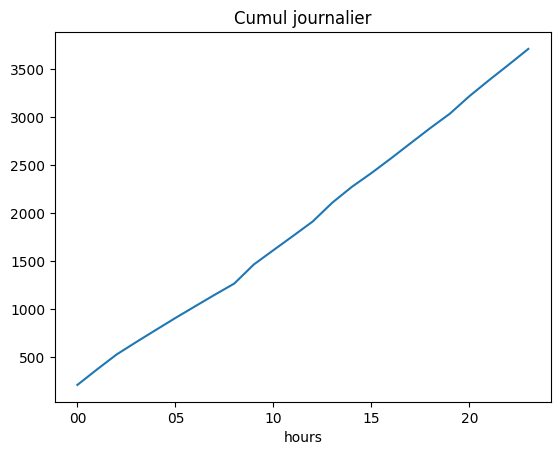

In [68]:
# progression sans surprise
grp_by_dayhours.loc['26/08/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

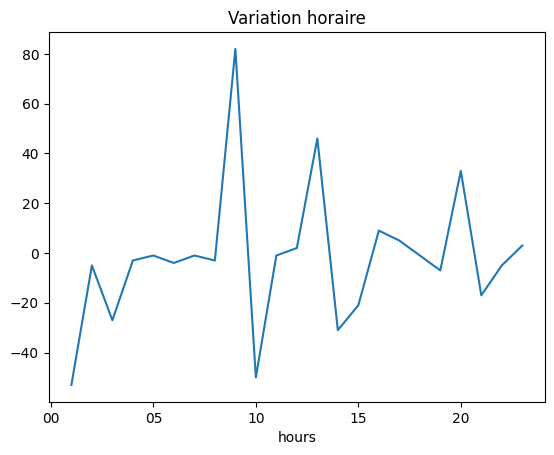

In [69]:
# plus parlant
grp_by_dayhours.loc['26/08/24']['diff'].plot()
plt.title(r'Variation horaire')

In [70]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

541

In [71]:
df_grp.tail(n)['kWh'].describe()


count    541.000000
mean       3.515549
std        0.671900
min        0.567000
25%        3.353000
50%        3.623000
75%        3.881000
max        5.052000
Name: kWh, dtype: float64

In [72]:
maxday = df_grp.tail(n)['kWh'].idxmax()

Text(0.5, 1.0, '541 days')

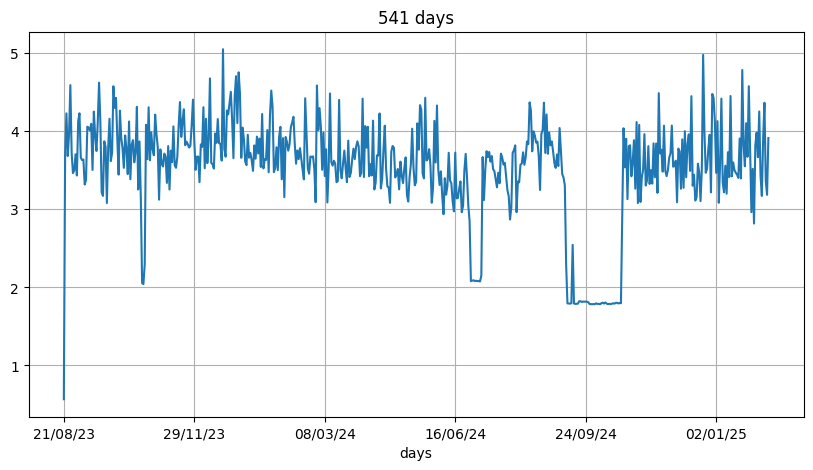

In [73]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

Text(0.5, 1.0, '400 days')

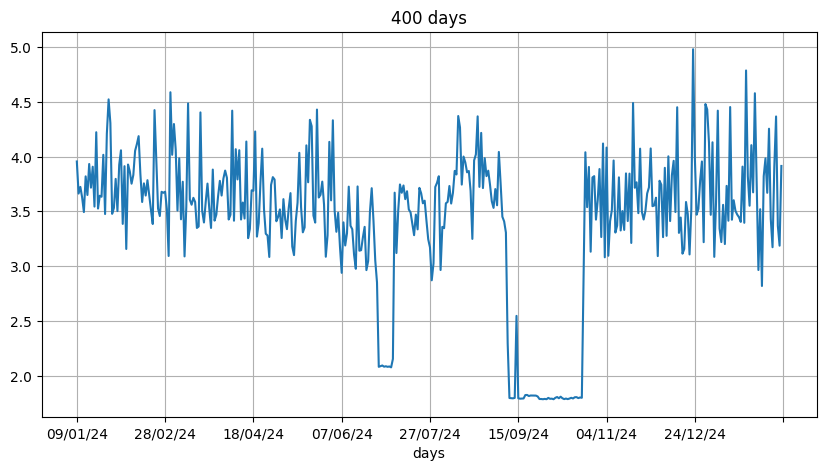

In [74]:
# show conso in span 
span = 400
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

In [75]:
df_grp['kWh']

days
21/08/23    0.567
22/08/23    3.701
23/08/23    4.230
24/08/23    3.683
25/08/23    3.961
            ...  
07/02/25    3.908
08/02/25    4.366
09/02/25    3.367
10/02/25    3.186
11/02/25    3.914
Name: kWh, Length: 541, dtype: float64

In [76]:
df_grp.describe()

,kWh
count,541.000000
mean,3.515549
std,0.671900
min,0.567000
25%,3.353000
50%,3.623000
75%,3.881000
max,5.052000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

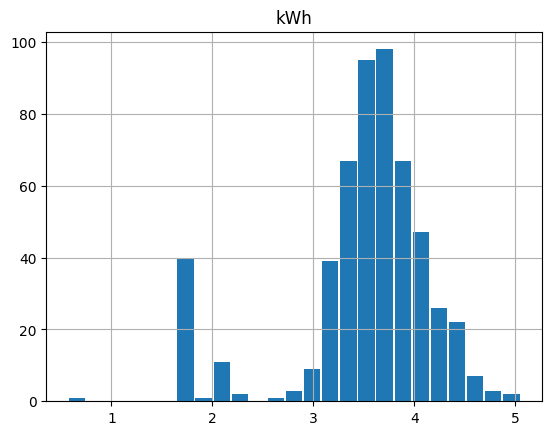

In [77]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [78]:
df_grp.tail(span)['kWh']

days
09/01/24    3.955
10/01/24    3.662
11/01/24    3.723
12/01/24    3.627
13/01/24    3.493
            ...  
07/02/25    3.908
08/02/25    4.366
09/02/25    3.367
10/02/25    3.186
11/02/25    3.914
Name: kWh, Length: 400, dtype: float64

# Conso par heure

In [79]:
day

'11/02/25'

In [80]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,154,154,NaN
01,122,276,-32.0
02,122,398,0.0
03,121,519,-1.0
04,111,630,-10.0
05,120,750,9.0
06,120,870,0.0
07,107,977,-13.0
08,181,1158,74.0


In [81]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


23

In [82]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 24)

In [83]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [84]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23.])

In [85]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
21    22.0
22    23.0
Name: days, dtype: float64

In [86]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [87]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 23 entries, 00 to 22
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     23 non-null     int64  
 1   cumsum  23 non-null     int64  
 2   diff    22 non-null     float64
 3   days    23 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 920.0+ bytes


In [88]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
21    22.0
22    23.0
Name: days, dtype: float64

In [89]:
day

'11/02/25'

In [90]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,154,154,NaN,1.0
01,122,276,-32.0,2.0
02,122,398,0.0,3.0
03,121,519,-1.0,4.0
04,111,630,-10.0,5.0
05,120,750,9.0,6.0
06,120,870,0.0,7.0
07,107,977,-13.0,8.0
08,181,1158,74.0,9.0


Text(0.5, 1.0, '11/02/25')

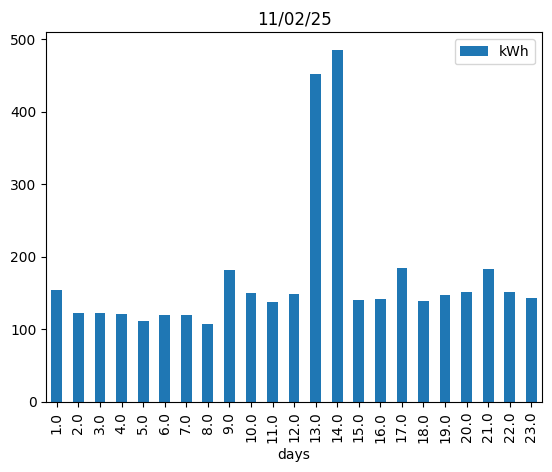

In [91]:
grp_by_dayhours.loc[day][['days','kWh']].plot.bar(x='days')
plt.title(f'{day}')

In [92]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22'],
      dtype='object', name='hours')

# Conso du jour


In [93]:
groupedbyhour.count()

,kWh
hours,
00,154
01,122
02,122
03,121
04,111
05,120
06,120
07,107
08,181


In [94]:
day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh

hours
00    161
01    155
02    167
03    151
04    170
05    165
06    147
07    138
08    115
09    131
10    130
11    114
12    131
13    120
14    178
15    156
16    138
17    157
18    986
19    220
20    285
21    297
22    315
23    325
Name: kWh, dtype: int64

In [95]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

366.406

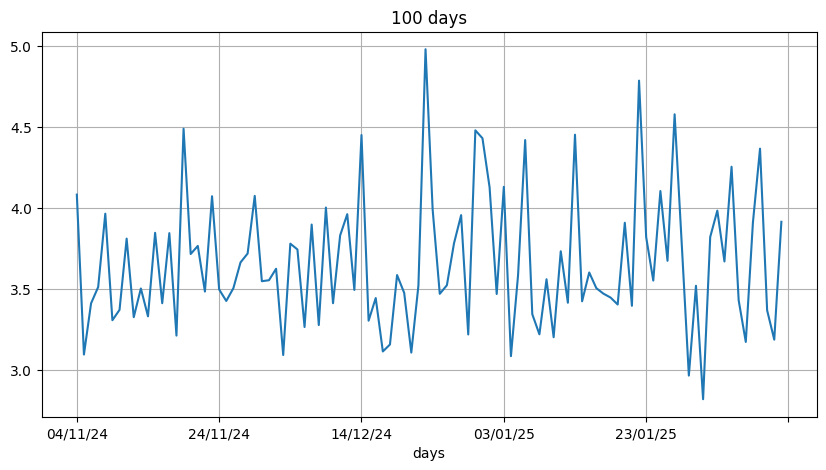

In [96]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')
sum(df_grp.tail(span)['kWh'])

In [97]:
df_grp.tail(1)

,kWh
days,
11/02/25,3.914


In [98]:
span = 1
#df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
#plt.title(f'{span} days')
sum(df_grp.tail(span)['kWh'])

3.914

In [99]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(end - start)

105.03019142150879


# Today

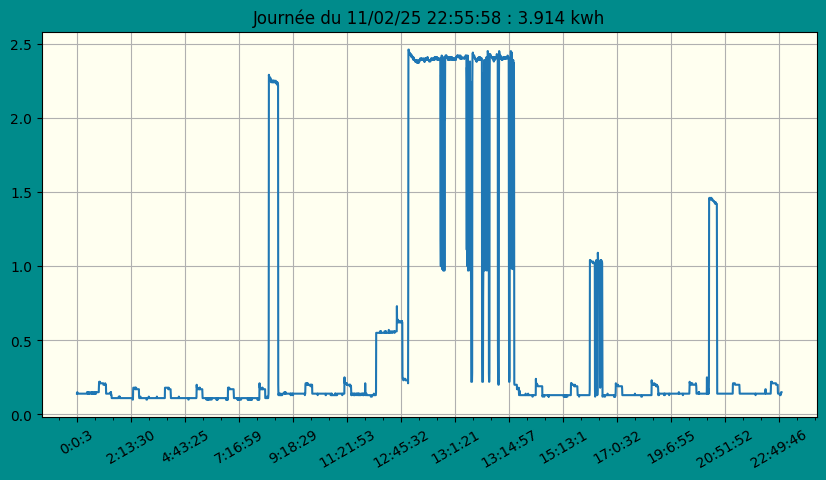

In [100]:
show(today,bgcolor='ivory')

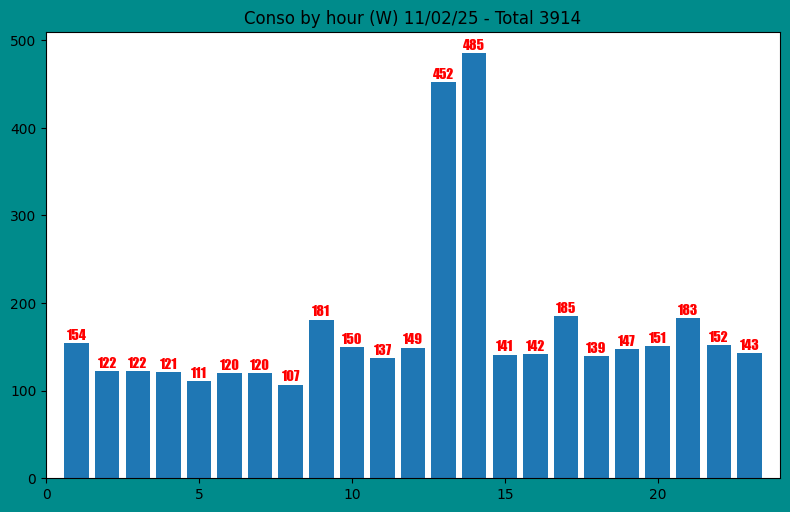

In [101]:
conso_by_hour(today)

In [102]:
day = '16/01/25'

('16/01/25', None)

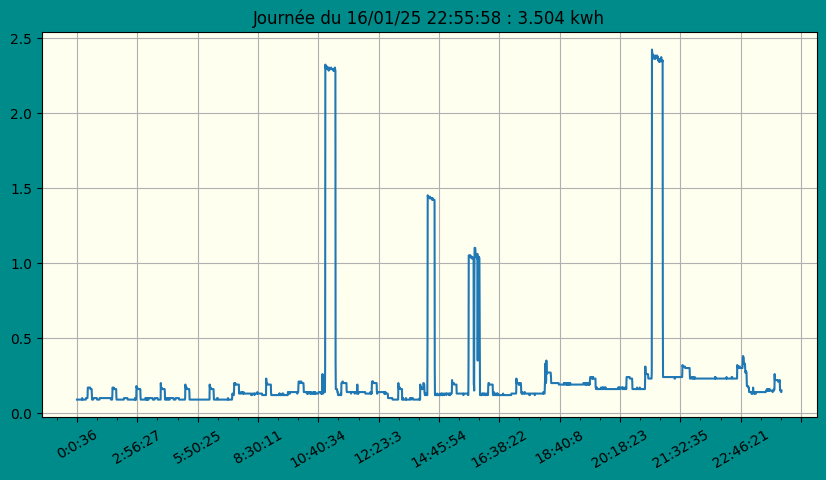

In [103]:
day, show(day,bgcolor='ivory')

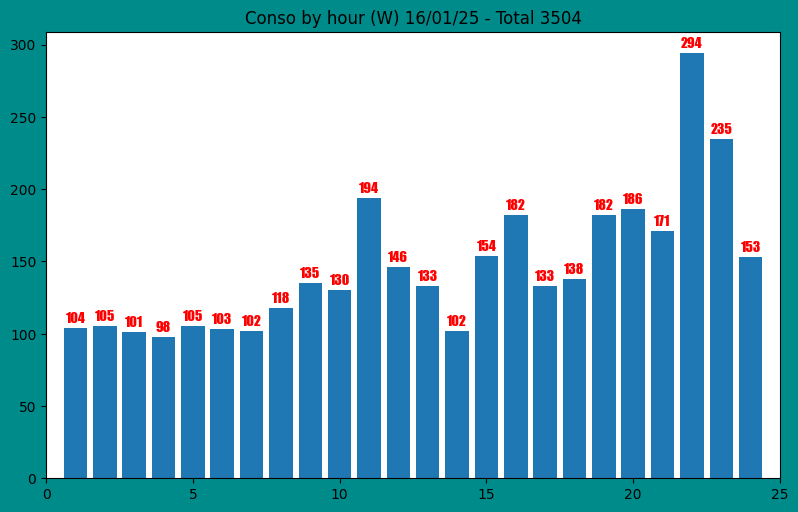

In [104]:
conso_by_hour(day)

In [105]:
maxday

'21/12/23'

('21/12/23', None)

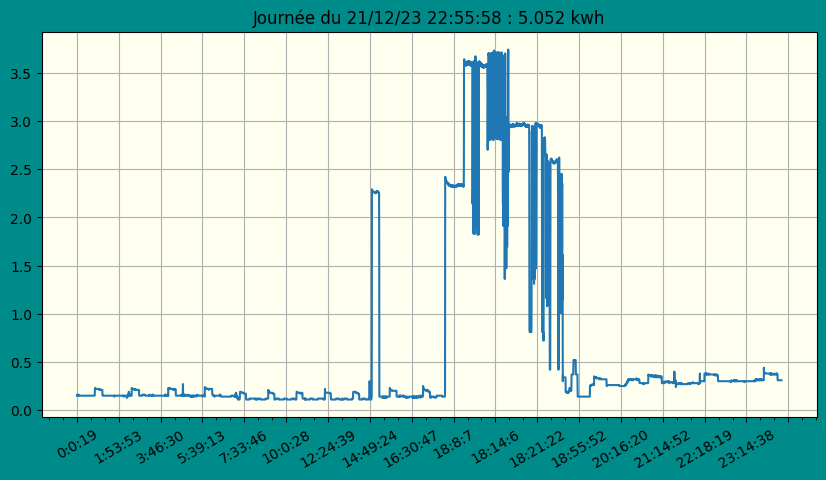

In [106]:
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')

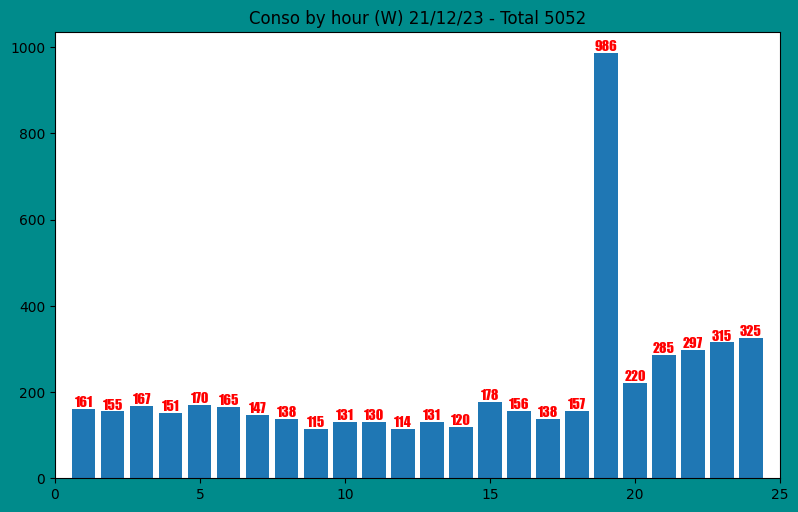

In [107]:
conso_by_hour(day)

In [108]:
sum(data)

5052

In [109]:
diff = grp_by_dayhours.loc[today]
diff


,kWh,cumsum,diff,days
hours,,,,
00,154,154,NaN,1.0
01,122,276,-32.0,2.0
02,122,398,0.0,3.0
03,121,519,-1.0,4.0
04,111,630,-10.0,5.0
05,120,750,9.0,6.0
06,120,870,0.0,7.0
07,107,977,-13.0,8.0
08,181,1158,74.0,9.0


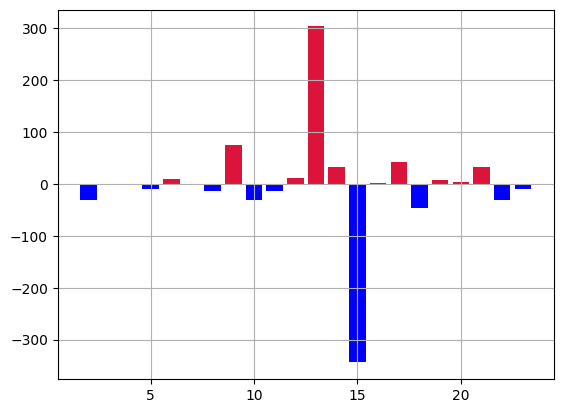

In [110]:
x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

In [111]:
data

hours
00    161
01    155
02    167
03    151
04    170
05    165
06    147
07    138
08    115
09    131
10    130
11    114
12    131
13    120
14    178
15    156
16    138
17    157
18    986
19    220
20    285
21    297
22    315
23    325
Name: kWh, dtype: int64

<Axes: xlabel='hours'>

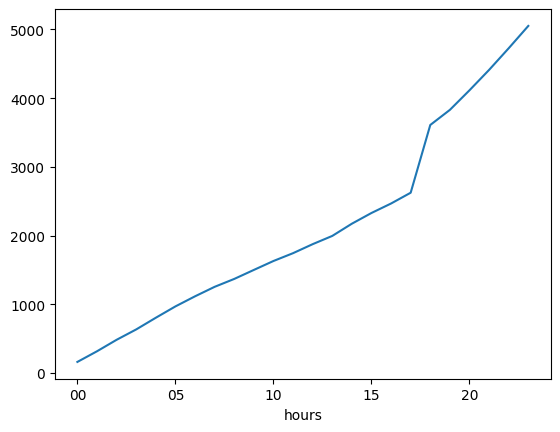

In [112]:
data.cumsum().plot()


<Axes: xlabel='hours'>

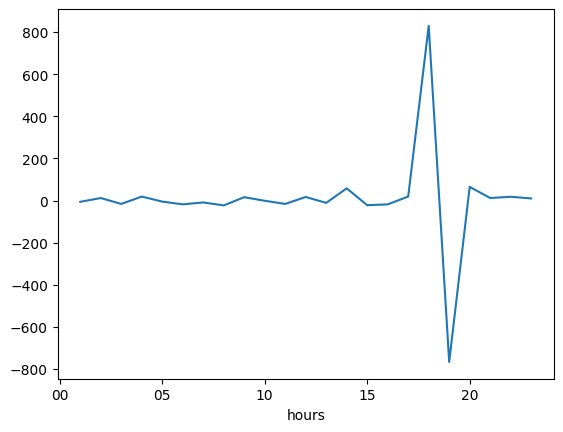

In [113]:
# evolution par heure
data.diff().plot()

In [114]:
data.diff().describe()

count     23.000000
mean       7.130435
std      241.663986
min     -766.000000
25%      -16.000000
50%       -1.000000
75%       17.500000
max      829.000000
Name: kWh, dtype: float64

<Axes: >

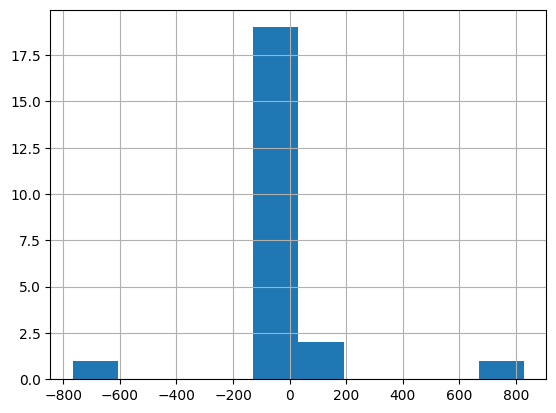

In [115]:
data.diff().hist()

# Test sauvegarde

In [116]:
import os
os.listdir(path='.')

['.git',
 '.gitignore',
 '.git_old',
 '.ipynb_checkpoints',
 '1row.flf',
 '5_days_meteo.ipynb',
 '8days.csv',
 '8days.pkl',
 '8days_dump.json',
 '8days_to_json.json',
 'advanced_expression.ipynb',
 'alphabeta_tree.ipynb',
 'amlich.ipynb',
 'amlich5.ipynb',
 'amlich5_test.ipynb',
 'amlich_data.py',
 'amlich_functions.py',
 'amlich_lib.py',
 'amlich_soc_tiet.ipynb',
 'AntPath.ipynb',
 'Apple.csv',
 'astronomie_def.ipynb',
 'atom_electronic_configuration.ipynb',
 'average_binding_energy_by_nucleons.ipynb',
 'bar_label.ipynb',
 'bell_curve.ipynb',
 'bitcoin_api.ipynb',
 'bitmap_convert.ipynb',
 'bitmap_structure.ipynb',
 'CAC40.csv',
 'chess_board.ipynb',
 'coindesk_api_client.ipynb',
 'collections.ipynb',
 'colormaps.ipynb',
 'conso.txt',
 'conso_by_hour.ipynb',
 'conso_data.csv',
 'conso_day_from_20230821.csv',
 'conso_jour.csv',
 'conso_jour.png',
 'conso_kwh.ipynb',
 'conso_kwh_reduced.ipynb',
 'conso_par_jour.csv',
 'covid19_france.ipynb',
 'cryptography_fernet.ipynb',
 'csv_readwrite

In [117]:
# list to store files
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

8days.csv
Apple.csv
CAC40.csv
conso_data.csv
conso_day_from_20230821.csv
conso_jour.csv
conso_par_jour.csv
data_temp16122022.csv
demain.csv
df.csv
df_grp.csv
DowJones.csv
EURUSD.csv
Ford.csv
karaoke.csv
ligue1_2020_27.csv
Nasdaq.csv
Nikkei.csv
planete.csv
saturn_bodies.csv
saturn_rings.csv
SMSSpamCollection.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
temp_humidity.csv
Tesla.csv
titanic.csv
Toyota.csv
VNDUSD.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
week.csv


In [118]:
#conso_byhour(day)

In [119]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


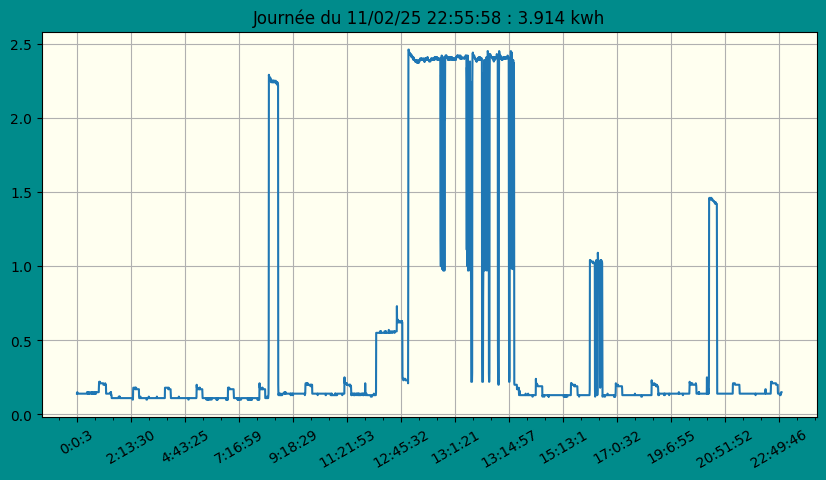

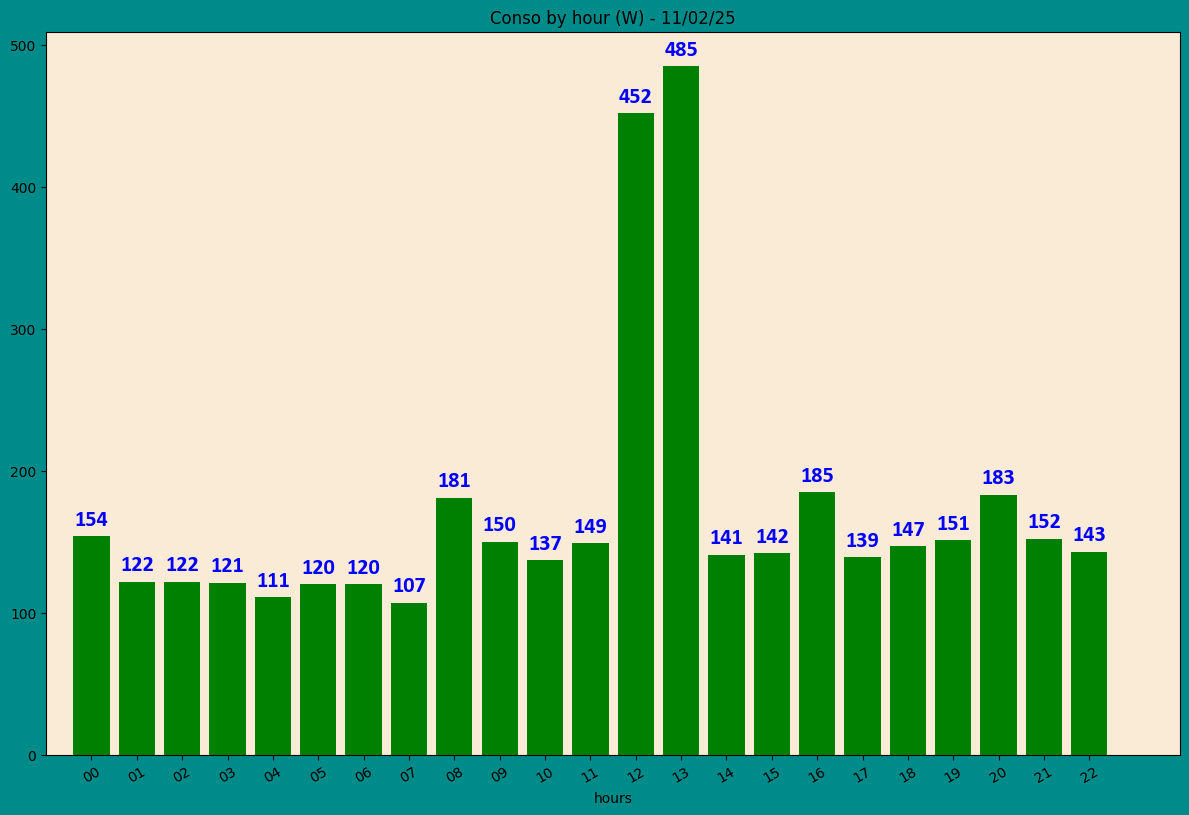

In [120]:
day = '27/10/24'
day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [121]:
month.describe()


count    30.000000
mean      3.692033
std       0.463794
min       2.818000
25%       3.416250
50%       3.576000
75%       3.908000
max       4.786000
Name: kWh, dtype: float64

<Axes: >

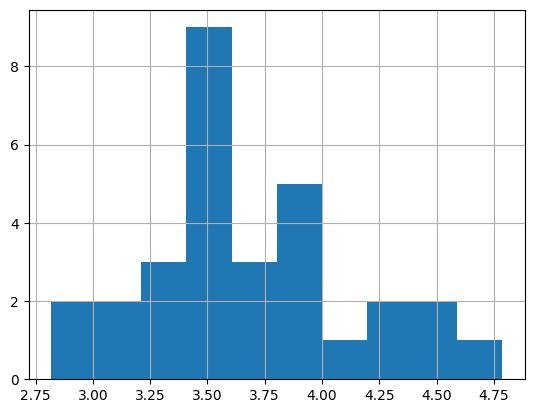

In [122]:
month.hist()

<Axes: xlabel='days'>

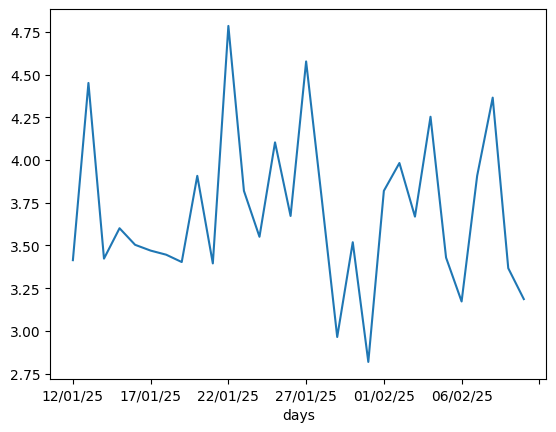

In [123]:
month.plot()

In [124]:
# date with max conso in 1 month
month.idxmax()

'22/01/25'

In [125]:
# plot month day max conso (télévision de 11h à 23h)
day = month.idxmax()
#day = '27/10/2024'
day

'22/01/25'

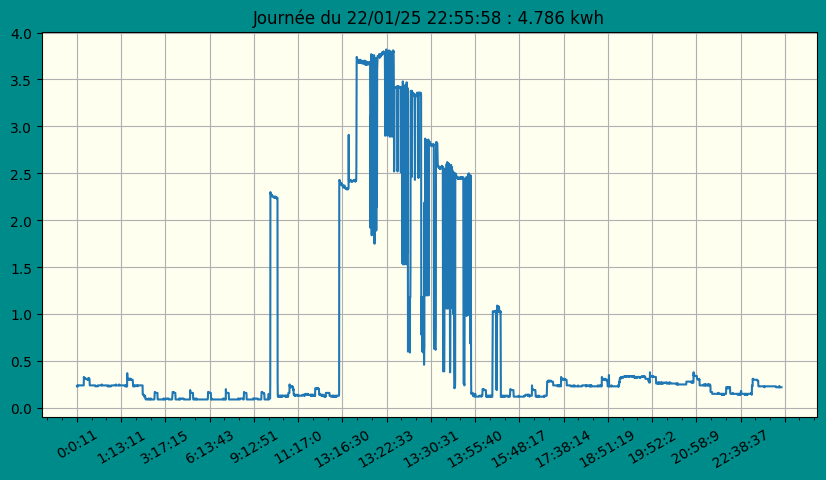

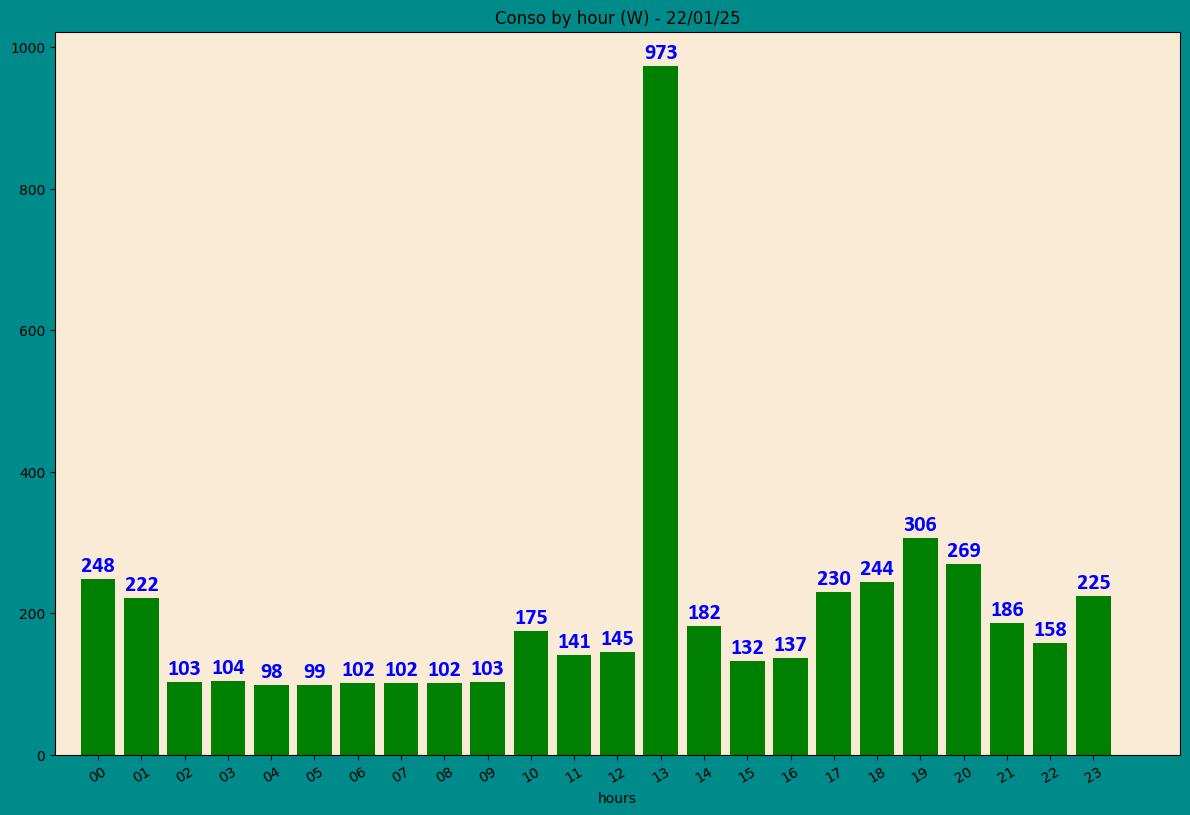

In [126]:
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [127]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
21/08/23 21     151     151    NaN   NaN
         22     286     437  135.0   NaN
         23     130     567 -156.0   NaN
22/08/23 00     129     129    NaN   NaN
         01     131     260    2.0   NaN
...             ...     ...    ...   ...
11/02/25 18     147    3285    8.0  19.0
         19     151    3436    4.0  20.0
         20     183    3619   32.0  21.0
         21     152    3771  -31.0  22.0
         22     143    3914   -9.0  23.0

[12962 rows x 4 columns]

In [128]:
grp_by_dayhours.loc[month.idxmax()]

,kWh,cumsum,diff,days
hours,,,,
00,248,248,NaN,NaN
01,222,470,-26.0,NaN
02,103,573,-119.0,NaN
03,104,677,1.0,NaN
04,98,775,-6.0,NaN
05,99,874,1.0,NaN
06,102,976,3.0,NaN
07,102,1078,0.0,NaN
08,102,1180,0.0,NaN


In [129]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

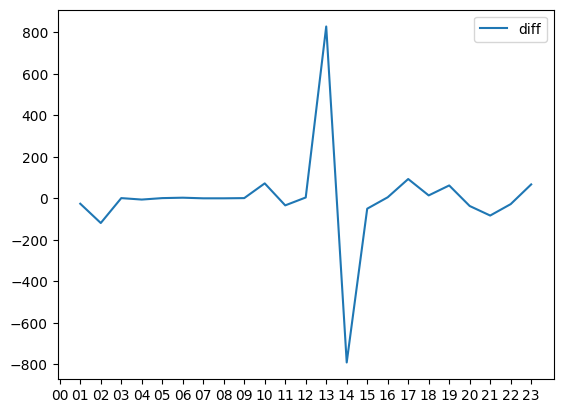

In [130]:
# diff
plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
plt.legend()

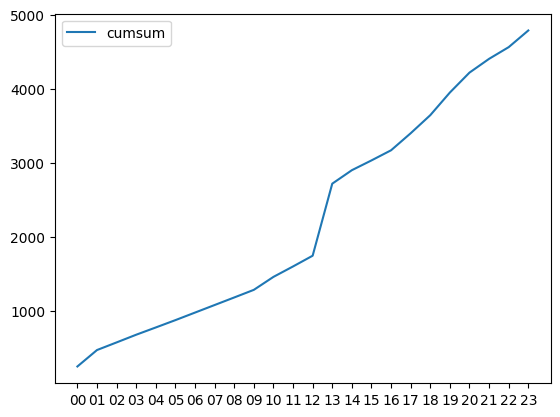

In [131]:
# cumsum
plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
plt.legend()

In [132]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB